In [1]:
# !pip install scipy
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt

In [2]:
# create Scores
scoresGood = np.random.normal(loc=20, scale=20, size=950000)
scoresBad = np.random.normal(loc=-10, scale=20, size=50000)

#create defaults
defaults = np.hstack([np.repeat(0, len(scoresGood)), np.repeat(1, len(scoresBad))])  
scores = np.hstack([scoresGood, scoresBad])

#create marks 
marks = np.quantile(np.sort(scores), (0.1, 0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9))
marks = np.hstack([[-999999], marks, [999999]])

#transform into pandas.DataFrame
data = pd.DataFrame(
    {'Score' : scores,   'Ausfall' : defaults}
)

#apply calibration/marks
data.insert(
             loc = 2
        ,    column = 'Note'
        ,    value = pd.cut(x = scores, bins = marks, labels = (10,9,8,7,6,5,4,3,2,1))
    )

data.insert(
             loc = 3 # 4
        ,    column = 'Stichtag'
        ,    value =  np.abs(np.round(np.random.normal(loc=6, scale=2, size=1000000)))
    )
data

,Score,Ausfall,Note,Stichtag
0,21.468545,0,5,6.0
1,33.494469,0,3,8.0
2,9.388572,0,7,9.0
3,-7.799429,0,9,6.0
4,9.627247,0,7,6.0
...,...,...,...,...
999995,9.724856,1,7,2.0
999996,-8.505713,1,9,4.0
999997,-19.118065,1,10,8.0
999998,-21.804467,1,10,6.0


In [3]:
# #write data to csv
# data.loc[:,['Note','Score','Ausfall','Stichtag']].to_csv('BspData.csv', index = False, sep = ';', decimal = '.')

# #write Master Scala to csv
# # calc real default rate
# scala = data.groupby(by="Note", dropna=False).mean()
# # put some uncertainty on PD
# scala['Ausfall'] = scala['Ausfall'] *  (0.8 + 0.2 / ( 1 + np.exp(np.random.normal(loc=0, scale=1, size=len(scala)))))
# scala.reset_index().loc[:,['Note','Ausfall']].rename(columns={'Ausfall':'PD'}).to_csv('BspMasterSkala.csv', index = False, sep = ';', decimal = '.')

In [4]:
# select data of Stichtag 5 and ignore the other days
data_Stichtag5 = data.loc[data['Stichtag'] == 5.0]
data_Stichtag5

,Score,Ausfall,Note,Stichtag
6,16.105661,0,6,5.0
8,35.128709,0,3,5.0
10,36.199135,0,2,5.0
11,14.998574,0,6,5.0
13,8.737144,0,7,5.0
...,...,...,...,...
999960,11.315840,1,7,5.0
999961,-10.210577,1,10,5.0
999973,-28.377067,1,10,5.0
999979,-41.461159,1,10,5.0


In [5]:
# get all unique "Note"
noten = sorted(data_Stichtag5["Note"].unique().__array__())
# print(noten)

# get the total counts of each "Note"
ns = data_Stichtag5["Note"].value_counts().sort_index(ascending=False)
# print(ns)

# group by "Note" and compute the mean for getting the PD (as showed in the example code)
scala = data_Stichtag5.groupby(by="Note").mean().sort_index(ascending=False)
# put some uncertainty on PD
ps = scala['Ausfall'] *  (0.8 + 0.2 / ( 1 + np.exp(np.random.normal(loc=0, scale=1, size=len(scala)))))
# print(ps)

# group by "Note" and count the number of "Ausfall", i.e., how many "1" is in the data for each "Note"
ks = data_Stichtag5.groupby(by="Note")['Ausfall'].apply(lambda x: (x==1).sum()).sort_index(ascending=False)
# print(xs)

In [6]:
# compute the confidence interval using the binomal distribution with a confidence level of 95%
conf_upper = []
conf_lower = []

for note in noten:
    k = ks.loc[note] # k indicates the successes of each "Note"
    n = ns.loc[note] # n is the sample size of each "Note"
    p = ps.loc[note] # p is the probability, of how often someone drops out
    
    # apply the binomial test using the library scipy
    bi_test = stats.binomtest(k, n=n, p=p, alternative='two-sided')
    # print(bi_test)
    print(f"Binomialtest für Note {note}: Teststatistik: {bi_test.statistic} und p-Wert: {bi_test.pvalue}")
    
    # the object of binomtest has also an attribute for accessing the confidence interval 
    # with a corresponding confidence level
    conf_interval = bi_test.proportion_ci(confidence_level=0.95)
    conf_upper.append(conf_interval.high) # save the upper confidence interval
    conf_lower.append(conf_interval.low) # save the lower confidence interval

Binomialtest für Note 1: Teststatistik: 0.001356085433382303 und p-Wert: 0.7532932720492407
Binomialtest für Note 2: Teststatistik: 0.0037502884837295174 und p-Wert: 0.3219325684019019
Binomialtest für Note 3: Teststatistik: 0.007090137734642878 und p-Wert: 0.6428280747224906
Binomialtest für Note 4: Teststatistik: 0.0113544201135442 und p-Wert: 0.023830295253761825
Binomialtest für Note 5: Teststatistik: 0.015726867208052157 und p-Wert: 0.07243564663628782
Binomialtest für Note 6: Teststatistik: 0.023629705916008697 und p-Wert: 0.01286980541964466
Binomialtest für Note 7: Teststatistik: 0.03226351351351351 und p-Wert: 0.05205294994160656
Binomialtest für Note 8: Teststatistik: 0.054981634527089075 und p-Wert: 0.017449043126447045
Binomialtest für Note 9: Teststatistik: 0.088037787389028 und p-Wert: 5.861222088527892e-08
Binomialtest für Note 10: Teststatistik: 0.2701587483523411 und p-Wert: 6.492692942514921e-05


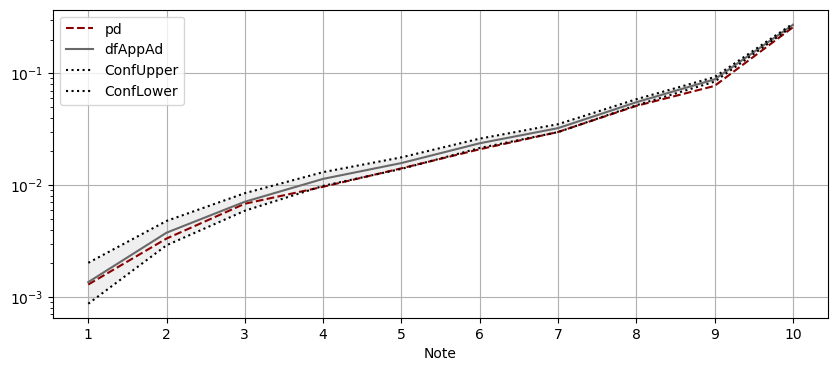

In [7]:
plt.figure(figsize=(10, 4))
# logarithm scale y-axis
plt.yscale("log") 
# plot prognotisierte Ausrallrate und gemessene Ausfallrate
plt.plot(noten, ps, label='pd', linestyle='dashed', color='darkred')
plt.plot(noten, ks/ns, label='dfAppAd', color='dimgray')

# plot confidence interval 
plt.plot(noten, conf_upper, label='ConfUpper', linestyle='dotted', color='black')
plt.plot(noten, conf_lower, label='ConfLower', linestyle='dotted', color='black')
plt.fill_between(noten, conf_lower, conf_upper, facecolor='dimgray', alpha=0.1)

plt.xticks(noten)
plt.xlabel("Note")
plt.grid(True)
plt.legend()
plt.show()

Man kann erkennen, dass die Kalibrierung der prognostizierten Ausfallrate (PD) der Noten im unteren Bereich (besonders 1 bis 4) gegen die gemessene Ausfallrate gut ist. Hingegen die Kalibrierung im oberen Bereich (besonders die Note 8 bis 10) keine so gute Kalibrierung zw. prognostizierten Ausfallrate und die gemessene Ausfallrate ist, da die PD außerdem des Konfidenzintervalls liegt und man einen signifikanten Unterschied zwischen der prognostizierten und gemessenen Ausfallrate erhält.

# Aufgabe 2

In [8]:
num = 1
x_length = []
# generate a sequence of [10, 100, 1000, ...]
for i in range(4):
    num *= 10
    x_length.append(num)
x_length = x_length

In [9]:
import timeit
import numba
import cProfile

#x sei 2 dimensionales Array
def summiereExpNumpy(x):
    return np.sum( np.exp(x) )

#x sei 2dimensionales Array
@numba.jit( nopython=True)    
def summiereExpNumba(x):
    nx, ny = x.shape
    val = 0.0
    for ix in range(nx):
        for iy in range(ny):
            val += np.exp(x[ix, iy])
    return val

In [10]:
# evaluate both functions using timeit
for n in x_length:
    x = np.random.rand(n,n)
    time_numpy = timeit.timeit(lambda: summiereExpNumpy(x), number=10)
    time_numba = timeit.timeit(lambda: summiereExpNumba(x), number=10)
    print(f"Time needed for numpy Function with array of size {n}x{n} using timeit: {time_numpy}")
    print(f"Time needed for numba Function with array of size {n}x{n} using timeit: {time_numba}")
    print('----'*20)

Time needed for numpy Function with array of size 10x10 using timeit: 0.00021019999999971617
Time needed for numba Function with array of size 10x10 using timeit: 0.24476800000000054
--------------------------------------------------------------------------------
Time needed for numpy Function with array of size 100x100 using timeit: 0.0006073999999998136
Time needed for numba Function with array of size 100x100 using timeit: 0.0005462000000004963
--------------------------------------------------------------------------------
Time needed for numpy Function with array of size 1000x1000 using timeit: 0.07190389999999969
Time needed for numba Function with array of size 1000x1000 using timeit: 0.06877430000000029
--------------------------------------------------------------------------------
Time needed for numpy Function with array of size 10000x10000 using timeit: 7.4579279000000005
Time needed for numba Function with array of size 10000x10000 using timeit: 7.639482600000001
---------

In [11]:
# evaluate both function using cProfile
for n in x_length:
    x = np.random.rand(n,n)
    cProfile.run('summiereExpNumpy(x)')
    cProfile.run('summiereExpNumba(x)')
    print('----'*20)

         13 function calls in 0.000 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    0.000    0.000 2461964603.py:6(summiereExpNumpy)
        1    0.000    0.000    0.000    0.000 <__array_function__ internals>:177(sum)
        1    0.000    0.000    0.000    0.000 <string>:1(<module>)
        1    0.000    0.000    0.000    0.000 fromnumeric.py:2157(_sum_dispatcher)
        1    0.000    0.000    0.000    0.000 fromnumeric.py:2162(sum)
        1    0.000    0.000    0.000    0.000 fromnumeric.py:69(_wrapreduction)
        1    0.000    0.000    0.000    0.000 fromnumeric.py:70(<dictcomp>)
        1    0.000    0.000    0.000    0.000 {built-in method builtins.exec}
        1    0.000    0.000    0.000    0.000 {built-in method builtins.isinstance}
        1    0.000    0.000    0.000    0.000 {built-in method numpy.core._multiarray_umath.implement_array_function}
        1    0.000    0.000   

Man kann beobachten, dass die Funktion, die `numba` verwendet, sowohl bei Verwendung von `timeit` als auch bei der Verwendung von `cProfile` schneller ist als die Funktion, die mit `numpy` arbeitet, besonders bei sehr großen Daten.

# Aufgabe 3
### Benenne bitte die Unterschiede zwischen folgenden Parallelisierungsvarianten-/bibliothekten:
- <b>Threading:</b> Threading ist eine integrierte Python-Bibliothek, die es ermöglicht, mehrere Threads innerhalb eines einzigen Prozesses auszuführen. Threads können sich denselben Memory Space teilen, was die Kommunikation erleichtern kann. Allerdings kann nur ein Thread gleichzeitig Python Bytecode ausführen, was die Effektivität von Threading bei CPU gebundenen Aufgaben einschränkt.

- <b>Multiprocessing:</b> Multiprocessing ist ebenfalls eine integrierte Python-Bibliothek, die es ermöglicht, mehrere Prozesse parallel auf verschiedene CPUs/Kernen auszuführen. Jeder Prozess hat hier seinen eigenen Memory Space, wodurch die Kommunikation hier komplizierter macht. Multiprocessing kann sowohl für CPU-gebundene als auch für I/O-gebundene Aufgaben verwendet werden.

- <b>concurrent.futures.ProcessPoolExecutor:</b> concurrent.futures.ProcessPoolExecutor ist eine Bibliothek, die eine High-Level Schnittstelle als asynchrone Ausführung von Funktionen unter Verwendung von Prozessen bietet. Dabei verwendet sie die Bibliothek multiprocessing, wodurch ermöglicht wird, Funktionen zur parallelen Ausführung zu übermitteln und dann die Ergebnisse abzurufen, sobald sie verfügbar ist.

- <b>Numba:</b> Numba ist ein just-in-time (JIT) Compiler, der die Leistung von numerischen Berechnungen verbessern soll (vgl. Aufgabe 2). Die Bibliothek ermöglicht es, den Python-Code im laufenden Betrieb in Maschinencode zu kompilieren, was bei bestimmten Arten von numerischen Berechnungen zur Verbesserung der Geschwindigkeit führen kann (z.B. bei Arrays, wie in Aufgabe 2 gesehen). 

- <b>Ray:</b> Ray ist eine Bibliothek zum Erstellen von Anwendungen in Python, die eine einfache und effizente Möglichkeit anbietet, Python-Code auf einem Cluster von Maschinen auf einer einzelnen Maschine auszuführen. Ray kann sowohl für CPU-gebundene als auch für I/O-gebundene Aufgaben (wie Multiprocessing) verwenden werden. Außerdem unterstützt Ray eine Vielzahl von Parallelitätsmustern, wie z.B. Aufgaben- und Datenparallelität.

### Wie kann man in Python parallelisieren und gleichzeitig shared memory nutzen?

Es gbt mehrere Methoden, um den Speicherbereich zu teilen, z.B. mit Multiprocessing:

- <b>multiprocessing.shared_memory:</b> Dieses Model bietet eine Möglichkeit an, Shared Memory Blöcke zu erstellen, auf die mehrere Prozesse zugreifen können. Dadurch wird der Austausch der Daten zwischen den Prozessen auch ermöglicht.
- <b>multiprocessing.Array:</b> Diese Klasse bietet eine Möglichkeit, gemeinsam genutzte Arrays zu erstellen, auf die mehrere Prozesse zugreifen können.
- <b>multiprocessing.Queue:</b> Die Klasse bietet eine Möglichkeit zur Kommunikation zwischen Prozessen mithilfe einer Warteschlange. Diese kann verwendet werden, um Nachrichten zwischen Prozessen weiterzuleiten oder Daten zwischen ihnen auszutauschen.

Mit Threding:
- <b>threading.Lock:</b> Die Klasse ermöglicht es, den Zugriff auf gemeinsame Ressourcen zwischen Threads zu synchronisieren.
- <b>threading.Condition:</b> Die Klasse ermöglicht es, die Kommunikation zwischen Threads zu koordinieren. Sie kann verwendet werden, um zu signalisieren, wenn eine gemeinsame Ressource verfügbar ist oder wenn eine Bedingung erfüllt wurde.

### Was ist der Vorteil von PySpark DataFrame vs. Pandas DataFrame, wie würde sich eine Nutzung auf kompatible Machine Learning Bibliotheken auswirken?

Der Hauptvorteil von PySpark DataFrame gegenüber Pandas DataFrame is die Fähigkeit, große Datensätze in einer verteilten Rechenumgebung effizient verarbeiten/analysieren zu können, während Pandas DataFrame eher für kleinere Datensätze geeignet ist, die in den Speicher passen. Zusätzlich nutzt das PySpark DataFrame das Apache Spark-Framework, das es ermöglicht, Daten über einen Cluster von Rechnern zu verteilen und diese parallel zu verarbeiten. PySpark bietet auch ein SQL-ähnliches Interface für das Arbeiten mit DataFrames. <br>
Pandas bietet im Gegensatz viele Funktionen zur Datenmanipulation, die für die Verwendung auf einer einzigen Maschine optimiert sind. <br>
Bezüglich Machine Learning, PySpark DataFrame ist mit der Spark-Bibliothek für ML und MLlib kompatibel. Andererseits sind Pandas DataFrame mit mehreren "bekannteren" Python-Bibliotheken kompatibel, wie z.B. scikit-learn oder TensorFlow. Diese sind wie oben beschrieben, für die Verwendung auf einer einzigen Maschine für kleine/mittelgroße Datensätze (die in den Speicher passen) optimiert.